In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time

In [2]:
import os
os.chdir('..')
import proppy as pp

In [3]:
from pathlib import Path
path_figs = 'comparison/compact_sources_1e14m_ballistic/figures'
path_data = 'comparison/compact_sources_1e14m_ballistic/data'
path_data_raw = 'comparison/compact_sources_1e14m_ballistic/data/raw_data'
Path(path_figs).mkdir(parents=True, exist_ok=True)
Path(path_data).mkdir(parents=True, exist_ok=True)
Path(path_data_raw).mkdir(parents=True, exist_ok=True)

### "Compact" astrophysical sources

Charged particles (comsic rays (CRs)) are accelerated to high energies in astrophysical sources until the gyration radius exceeds the system size according to the Hillas criterion and the CRs can no longer be confined by the accelerator. Since strong magnetic fields with a significant amount of turbulence typically prevail in these sources, the description of particle propagation in the sources is nontrivial and complicate the analytical description of transport. 

Simulations are used for describing as accurately as possible the particle transport that has an impact on numerous observable mulstimessenger signatures. In the following, we focus on the transport properties in these sources, which are described by the diffusion coefficient (see the introductions in the previous tutorials).

There are numerous possible sources covering a large parameter space of physical properties relevant to particle transport. For the comparison between PropPy propagation and CRPropa modules, we use typical parameters used in the literature for AGN plasmoids:
- isotropic 3d Kolmogorov turbulence
- magnetic field strength: 1 Gaus
- correlation length turbulence: $\sim10^{11}$ m
- particle energies: 100 PeV

In [4]:
l_c = 10**11 # [m]
energy = 10**17 # [eV]

These parameters will result in gyroradii of the charged CRs:
\begin{align}
r_\mathrm{g} = \frac{\sqrt{2}E}{q\,c\,B} = \frac{141\,\mathrm{PeV}}{q\,c \cdot 1\mathrm{G}} \approx 4.72\cdot10^{12}\,\mathrm{m}.
\end{align}
Note that the factor $\sqrt{2}$ is introduced because of the isotropic directions of the magnetic field vectors in the turbulence.

In [5]:
r_g = 4.72*10**12 # [m]

Particles are in the quasi-ballistic transport regime ($r_\mathrm{g} \gg l_\mathrm{c}$), where they experience only minor deflections. The expected diffusion coefficient $\kappa$ is (see e.g. Subedi, P. et al. 2017, ApJ, 837, 140. doi:10.3847/1538-4357/aa603a):
\begin{align}
\kappa_\mathrm{theory} = \frac{r_\mathrm{g}^2 \cdot c}{2l_\mathrm{c}} = \frac{(4.72\cdot10^{12}\,\mathrm{m})^2 \cdot c}{2\cdot 10^{11}\,m} \approx 3.34\cdot10^{22}\,\frac{\mathrm{m^2}}{\mathrm{s}}.
\end{align}

In [6]:
kappa_theory = 3.34*10**22 # [m^2/s]

This theoretical diffusion coefficient serves as an input for the PropPy simulation and the Diffusion approach in CRPropa and as a reference for the numerical simulations.

This diffusion coefficient results in expected mean-free paths of
\begin{align}
\lambda_\mathrm{theory} = \frac{3 \kappa_\mathrm{theory}}{c} \approx 3.34\cdot10^{14}\,\mathrm{m}.
\end{align}
Particles become diffusive at trajectory lengths of about $\lambda$. Instead of waiting for particles to be diffusive as it is done in the other comparison notebook, we stop the simulation after trajectory lengths of only $10^{14}\,$m. Particles are still ballistic.

In [7]:
lambda_theory = 3.34*10**14 # [m]
traj_max = 10**14 # [m]

### Simulations with CRPropa
CRPropa is a state of the art propagation code that can propagate CRs by solving both the equation of motion (ballistic) and the transport equation (diffusive) in arbitrary magnetic fields.

#### Version
The following scripts use a log observer in order to observe only those time steps that are needed in the log-log comparison plot in the end. The branch https://github.com/reichherzerp/CRPropa3/tree/LogObserverTimeEvolution contains this log time observer. Make sure to use this branch for your simulations in CRPropa.

#### Installation
Following the installation of CRPropa in a virtuelenv as described in https://crpropa.github.io/CRPropa3/pages/Installation.html

#### Simulation
Run the **simulation script** *comparison/crp_sim_compact_sources_1e14m_ballistic.py* in your CRPropa environment:
This starts 19 simulations with varying step sizes of the integration routine. This convergence test is necessary to find the required resolution (step size) of the simulation routine that solves the equation of motion. The simulation results are evaluated by determining the diffusion coefficients, which provide a statistical description of the transport. 

Run the script with prop_module = 'CK', 'BP', and 'SDE' to get the results for all available CRPropa propagation modules.

#### Simulation results
After simulation, the raw data (position, momentum,..) of the simulations are stored in *path_data_raw* (default is */comparison/data/raw_data*). The analyzed data (diffusion coefficients, simulation time,..) are stored in *path_data* (default is */comparison/data*) and will be used in the following. 

#### Download simulation results
Instead of performing your own time-consuming simulations, you can download the simulation results from https://zenodo.org/record/5959618#.YgN0pD_MLZs, which were created on a large server.

### Simulations with PropPy
In the following we perform the same simulations as in CRPropa with PropPy.

#### Download simulation results
Instead of performing your own time-consuming simulations, you can download the simulation results from https://zenodo.org/record/5959618#.YgN0pD_MLZs, which were created on a large server.

In [8]:
step_sizes = np.logspace(9, 15, 19) # [m]

In [9]:
def proppy_sim():
    df_sim_data = pd.DataFrame(columns=('step_size', 'time', 'kappa', 'kappa_err'))

    fig = plt.figure(figsize=(5,3.5))
    # start with large step sizes first, as these simulations are faster
    step_sized_reversed = np.insert(step_sizes[::-1], 0, step_sizes[-1], axis=0)
    for i, step_size in enumerate(step_sized_reversed):
        print('______________________________________________________________')
        print('step_size: ', step_size)
        nr_steps = int(traj_max/step_size)
        sim = pp.IsotropicSimulation(nr_particles = 10**3, energy = energy, step_size = step_size, nr_steps = nr_steps, diffusion_coefficient_para = kappa_theory, nr_obs_steps = 100)
        file_name = path_data_raw+'/proppy_stepsize_'+str(step_size/10**11)
        start_time = time.process_time()
        %time sim.simulate(file_name)
        time_needed = time.process_time() - start_time
        print('time needed: ', time_needed, 's')
        df = pd.read_pickle(file_name+'.pkl')
        sta = pp.Statistics(df)
        df_kappas = sta.get_diffusion_coefficients()
        if i == 0:
            print('______________________________________________________________')
            print('Finished setup test - starting now with the convergence test!')
            continue
        df_sim_data.loc[i-1] = [step_size, time_needed, np.mean(df_kappas['kappa'][-10:]), np.std(df_kappas['kappa'][-10:])]
        plt.plot(df_kappas['l'], (df_kappas['kappa']))
        file_name = path_data+'/sim_result_proppy_'
        np.save(file_name+str(step_size/10**11)+'_l.npy', np.array(df_kappas['l']))
        np.save(file_name+str(step_size/10**11)+'_kappa.npy', np.array(df_kappas['kappa']))
        file_name_results = path_data+'/proppy_sim_data.pkl'
        df_sim_data.to_pickle(file_name_results)

    plt.loglog()

Run either the following simulation or the **simulation script** *comparison/proppy_sim_compact_sources_1e14m_ballistic.py*.

In [10]:
#proppy_sim()

## Comparison of simulation results

We compute the running diffusion coefficients and compute the effective diffusion coefficient after $10^{14}$m. Most particles are still ballistic, as can bes seen that the running diffusion coefficient is not yet converged. See the comparison for trajectory lengths of $10^{14}$m for the diffusive case.

In this ballistic limit investigated here, particles didn't scatter often yet and the running diffusion coefficients follow $\kappa_{ii}(t) \approx \frac{l_\mathrm{traj}^2}{2t} = \frac{l_\mathrm{traj}\,v_i}{2} \approx \frac{l_\mathrm{traj}\,c}{6}.$

In [11]:
kappa_theory_1e14 = 3*10**22/2/3 # [m^2/s]
comparison = pp.Comparison(kappa_theory_1e14, lambda_theory, step_sizes, l_c, r_g, path_data_raw, path_data, path_figs)

### Effect of different seeds for synthetic turbulence

Run script *comparison/crp_sim_compact_sources_1e17m_seed_analysis.py* with
parameters:
- maximal trajectory length: $10^{17}$ m
- step size: $10^{10}$ m 
- propagation module: PropagationBP
- turbulence: PlaneWave [PW] with 1000 modes

In [12]:
df_BP_PW_seeds = pd.read_pickle('comparison/compact_sources_1e17m_seed_analysis/data/crp_sim_data_BP_seed_.pkl')
kappa_bp_mean = np.mean(df_BP_PW_seeds['kappa'])
kappa_bp_mean_err = np.std(df_BP_PW_seeds['kappa'])
print(kappa_bp_mean, kappa_bp_mean_err)
print(kappa_bp_mean_err/kappa_bp_mean)
df_BP_PW_seeds

3.4084056678791345e+22 1.6031715453936557e+21
0.04703581972363114


,seed,time,kappa,kappa_err
0,0.0,747998.846886,3.484819e+22,2.684155e+20
1,1.0,743628.028511,3.402924e+22,2.290982e+20
2,2.0,740889.038331,3.431111e+22,1.856180e+20
3,3.0,732847.981820,3.499164e+22,3.519690e+20
4,4.0,732832.177757,3.417721e+22,8.408464e+20
5,5.0,732930.796841,3.334111e+22,3.306901e+20
6,6.0,732804.384330,3.280806e+22,4.708308e+20
7,7.0,732752.668989,3.229295e+22,2.899954e+20
8,8.0,732949.442820,3.439420e+22,5.519116e+20
9,9.0,732911.961054,3.516707e+22,4.842102e+20


### Running diffusion coefficients

Running diffusion coefficients can be modelled via
\begin{equation}
\kappa (t) = \kappa \cdot \left(1 - \mathrm{e}^{-t/\tau}\right),
\end{equation}
where $\kappa$ is the converged diffusion coefficient and $\tau$ can be deduced from the initial ballistic phase via
\begin{equation}
\tau = \frac{t}{\kappa(t)}
\end{equation}
for small $t$.
Note that this expression was derived by using the Taylor series of $\kappa (t)$ for small times
\begin{equation}
\kappa (t) \approx \frac{t}{\tau}.
\end{equation}

680734140121072.8 680734140121072.8


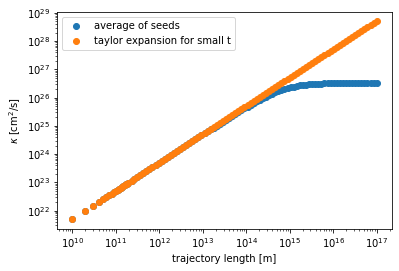

In [13]:
seeds = 20
for seed in range(seeds):
    l = np.load('comparison/compact_sources_1e17m_seed_analysis/data/sim_result_crp_BP_PW_stepsize_'+str(seed)+'_l.npy')
    kappa = np.load('comparison/compact_sources_1e17m_seed_analysis/data/sim_result_crp_BP_PW_stepsize_'+str(seed)+'_kappa.npy')
    if seed == 0:
        kappas = kappa
    if seed > 0:
        kappas = kappas + kappa
kappas = kappas/seeds

tau = l[0] / kappas[0] * kappas[-1]
print(tau, tau)
plt.scatter(l, kappas*10**4, label='average of seeds')
plt.scatter(l, (l/tau)*kappas[-1]*10**4, label='taylor expansion for small t')
plt.loglog()
plt.legend()
plt.ylabel('$\kappa$ [cm$^2$/s]')
plt.xlabel('trajectory length [m]')
plt.show()

### Running diffusion coefficients

missing data for PropPy


/home/patrick/Documents/proppy_project/proppy/proppy/comparison.py:303: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(pad=0.01, aspect=1000)


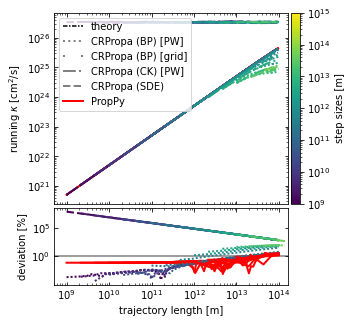

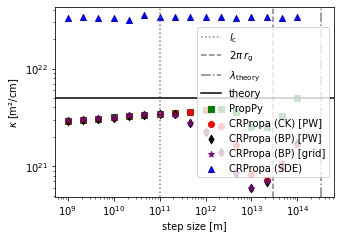

In [14]:
comparison.plot_running_diffusion_coefficients(d_theory=[1.1e14, 1.1e14], times=l, kappas_ref=kappas, show_lambda=False, index_last=-3)

Note that the color-code (cc) is only used for running diffusion coefficients simulated with PropPy, as the ones simulated with PropPy overlay (see red lines) -> the differences in the step sizes are not visible.

The lower plot is just for checking the raw data. The plot below is the same with better visualization.

### Convergence tests of diffusion coefficients

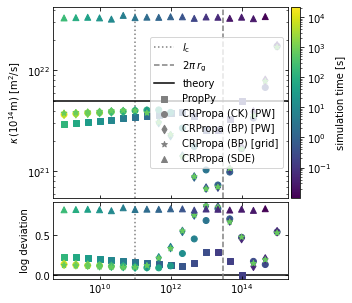

In [15]:
comparison.plot_kappa_convergence_tests(ylabel = '$\kappa\,(10^{14}\mathrm{m})$ [m$^2$/s]', lambda_theory=False)

For PropPy SImulations, the step size shown here does not appear to have a noticeable effect on the diffusion coefficients. The steps can be significantly larger than the correlation length of the turbulence and than the gyration radius of the particles. This is not surprising, since in the correlated random walk in Cartesian coordinates used in PropPy for isotropic turbulence, the gyration motion and the turbulence does not need to be resolved. The only deviation at large step sizes is a numerical artifact from the observer that doesn't observe at exactly $10^{14}$m, because only full steps can be observed and the observed distance may, therefore, be smaller than $10^{14}$m and thus resulting in a smaller diffusion coefficient.

Note that the theoretical prediction is only an upper limit, as it assumes pure, isotropic propagation. Some particles will be diffusive and thus decrease the effective diffusion coefficient at $10^{14}$m.

For CRPropa, on the other hand, the resolution plays a significant role in the integration of the particle trajectories. Only for small step sizes, when both the relevant scales of turbulence and gyration motion are resolved, does the diffusion coefficient converge against the prediction of the theory. As soon as the step size becomes larger than the correlation length of the turbulence, diffusion coefficients are wrong. See the appendix in Reichherzer (MNRAS, 2020) for a detailed discussion of this effect. If the step size is larger than the gyroradius, the diffusion coefficients increase again, because now averaging over the large steps becomes too large.

Note that the BP and CK simulation results obtained with CRPropa should be averaged over different realisations of the turbulence generated with the PlaneWaveTurbulence module, which would further increase the simulation time. At least 100 realizations are needed to become reasonable good simulation results. This would increase the simulation tiems by an additional factor of 100!

Also note that for BP and CK, the simulation time is a lower boundary, as only 250 modes, which is the minimum for the applied fluctuation wavelength range (Schlegel et al. (ApJ, 2020)), are used and the simulation time scales linearly with the number of modes.

The diffusion approach for the propagation fails in describing the transport, as most particles are not yet diffusive. See Reichherzer (ICRC, 2021) for a detailed discussion.

### Comparison of simulation times

Further plots to visualize different aspects of the comparison.

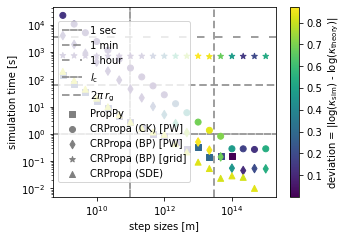

In [16]:
comparison.plot_time_vs_steps_deviation(day=False, lambda_theory=False)

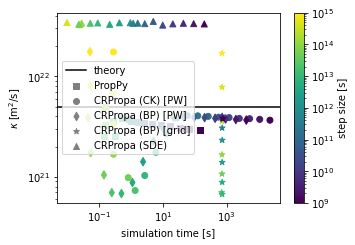

In [17]:
comparison.plot_kappa_vs_time_steps()

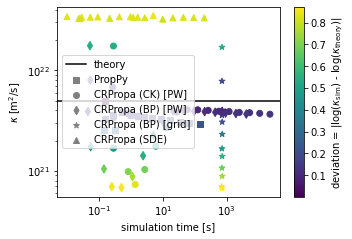

In [18]:
comparison.plot_kappa_vs_time_deviation()

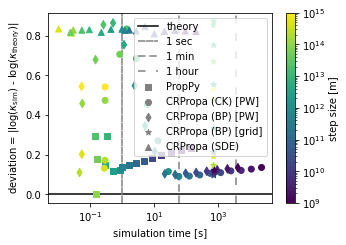

In [19]:
comparison.plot_deviation_vs_time_steps(day=False)

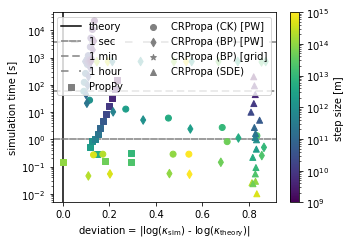

In [20]:
comparison.plot_time_vs_deviation_steps(day=False)